In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os

print("Packages imported...")

Packages imported...


In [16]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29

train_len = 87000
train_dir = 'asl_alphabet_train/asl_alphabet_train/'

def get_data(folder):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=int)
    cnt = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            else:
                label = 29
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    
                    X[cnt] = img_arr
                    y[cnt] = label
                    cnt += 1
    return X,y
X_train, y_train = get_data(train_dir)
print("Images successfully imported...")

Images successfully imported...


In [17]:
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)

The shape of X_train is :  (87000, 64, 64, 3)
The shape of y_train is :  (87000,)


In [18]:
print("The shape of one image is : ", X_train[0].shape)

The shape of one image is :  (64, 64, 3)


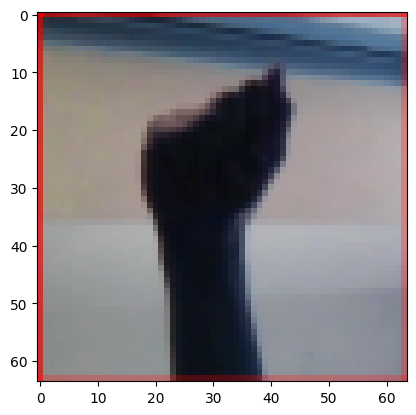

In [19]:
plt.imshow(X_train[0])
plt.show()

In [20]:
X_data = X_train
y_data = y_train
print("Copies made...")

Copies made...


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [22]:
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_cat_train.shape)
print(y_cat_test.shape)

(60900, 64, 64, 3)
(60900,)
(26100, 64, 64, 3)
(26100,)
(60900, 29)
(26100, 29)


In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
print("Packages imported...")

Packages imported...


In [25]:
model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(29, activation='softmax'))

model.summary()

C:\Users\Thuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 60, 60, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,637 (1.36 MB)

 Trainable params: 356,637 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.fit(X_train, y_cat_train,
          epochs=50,
          batch_size=64,
          verbose=2,
          validation_data=(X_test, y_cat_test),
         callbacks=[early_stop])

Epoch 1/50
952/952 - 55s - 57ms/step - accuracy: 0.6587 - loss: 1.1393 - val_accuracy: 0.8926 - val_loss: 0.3373
Epoch 2/50
952/952 - 50s - 52ms/step - accuracy: 0.9381 - loss: 0.1940 - val_accuracy: 0.9497 - val_loss: 0.1472
Epoch 3/50
952/952 - 54s - 57ms/step - accuracy: 0.9706 - loss: 0.0933 - val_accuracy: 0.9688 - val_loss: 0.1026
Epoch 4/50
952/952 - 50s - 53ms/step - accuracy: 0.9804 - loss: 0.0635 - val_accuracy: 0.9865 - val_loss: 0.0461
Epoch 5/50
952/952 - 49s - 51ms/step - accuracy: 0.9854 - loss: 0.0470 - val_accuracy: 0.9923 - val_loss: 0.0252
Epoch 6/50
952/952 - 53s - 56ms/step - accuracy: 0.9861 - loss: 0.0428 - val_accuracy: 0.9809 - val_loss: 0.0615
Epoch 7/50
952/952 - 53s - 56ms/step - accuracy: 0.9881 - loss: 0.0377 - val_accuracy: 0.9907 - val_loss: 0.0276


In [30]:
metrics = pd.DataFrame(model.history.history)
print("The model metrics are")
metrics

The model metrics are


,accuracy,loss,val_accuracy,val_loss
0,0.658719,1.139305,0.892567,0.337326
1,0.938079,0.194035,0.949655,0.147244
2,0.970608,0.093293,0.968774,0.102560
3,0.980411,0.063547,0.986475,0.046135
4,0.985353,0.047034,0.992337,0.025160
5,0.986141,0.042770,0.980881,0.061504
6,0.988128,0.037726,0.990728,0.027649


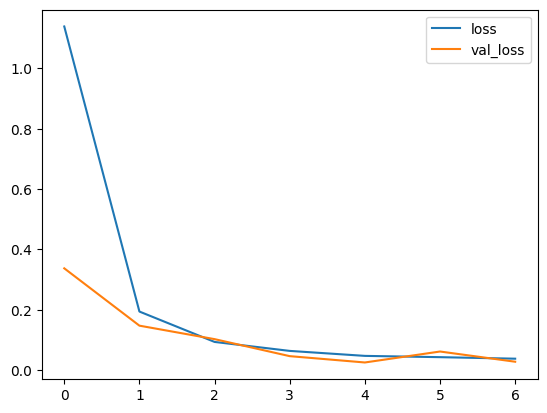

In [31]:
metrics[['loss','val_loss']].plot()
plt.show()

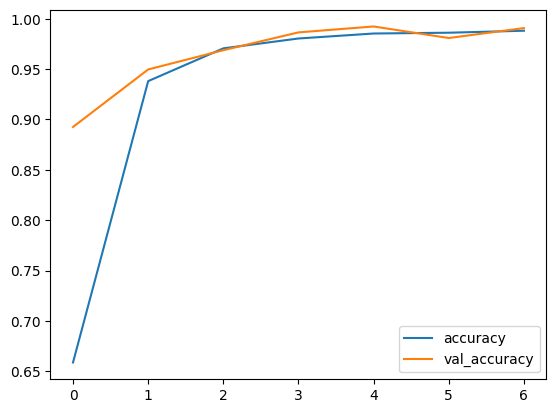

In [32]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

In [43]:
model.evaluate(X_test,y_cat_test,verbose=0)

[0.02764866128563881, 0.990727961063385]

In [46]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

816/816 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


In [47]:
classes_x

array([25, 26, 10, ..., 18,  3, 27], dtype=int64)

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,classes_x))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       900
           1       1.00      0.99      0.99       900
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       900
           4       0.98      0.98      0.98       900
           5       0.99      1.00      1.00       900
           6       1.00      1.00      1.00       900
           7       1.00      0.99      1.00       900
           8       0.99      0.99      0.99       900
           9       1.00      1.00      1.00       900
          10       0.97      1.00      0.99       900
          11       1.00      1.00      1.00       900
          12       1.00      0.96      0.98       900
          13       0.96      1.00      0.98       900
          14       1.00      0.99      0.99       900
          15       1.00      1.00      1.00       900
          16       1.00      1.00      1.00       900
          17       0.98    

In [51]:
model.save('ASL.keras')